# Generate spectrograms

Script to generate spectrogram from raw audio for each call.

In [1]:
import pandas as pd
import os
import librosa
import sys
import numpy as np
import pickle
from pathlib import Path
import librosa.display
import matplotlib.pyplot as plt

In [ ]:
from spectrogramming_functions import generate_mel_spectrogram, generate_stretched_mel_spectrogram, generate_freq_spectrogram, generate_ampli_spectrogram

In [2]:
wd = os.getcwd()

DATA = os.path.join(os.path.sep, str(Path(wd).parents[0]), "data", "processed")
RAW_DATA = os.path.join(os.path.sep, str(Path(wd).parents[0]), "data", "raw")
#DF_FULL = os.path.join(os.path.sep, DATA, "df_denoised")
DF_FULL = os.path.join(os.path.sep, RAW_DATA, "spec_df_all_April_2020")

In [3]:
# Spectrogramming parameters
FFT_WIN = 0.03 # FFT_WIN*samplerate = length of fft/n_fft (number of audio frames that go in one fft)
FFT_HOP = FFT_WIN/8 # FFT_HOP*samplerate = n of audio frames between successive ffts
N_MELS = 40 # number of mel bins
WINDOW = 'hann' # each frame of audio is windowed by a window function (its length can also be
# determined and is then padded with zeros to match n_fft. we use window_length = length of fft
FMAX = 4000
N_MFCC = 13

# Read in data

In [5]:
df = pd.read_pickle(DF_FULL)
df.shape

(21036, 20)

In [51]:
#df = df.drop(columns=['mfccs', 'mfcc_deltas', 'mfcc_deltadeltas', 'stretched_spectrograms', 'stretched_mfccs', 'stretched_mfcc_deltas','stretched_mfcc_deltadeltas',
#                'denoised_mfccs', 'denoised_stretched_mfccs', 'denoised_mfcc_deltas','denoised_stretched_mfcc_deltas'])

## Remove uncertain calls

In [6]:
df = df.loc[df.certain_yn == 'y',:]
df.shape

(20714, 20)

# Generate spectrogram columns

In [7]:
df.samplerate_hz.value_counts()

8000     17763
48000     2951
Name: samplerate_hz, dtype: int64

In [54]:
spectrograms = df.apply(lambda row: generate_mel_spectrogram(row['raw_audio'],
                                                             row['samplerate_hz'],
                                                             N_MELS,
                                                             WINDOW,
                                                             FFT_WIN,
                                                             FFT_HOP,
                                                             FMAX), 
                        axis=1)


df['spectrograms'] = spectrograms

denoised = [(spectrogram - np.median(spectrogram, axis=0)) for spectrogram in df['spectrograms']]
df['denoised_spectrograms'] = denoised

In [ ]:
# Show example spectrograms

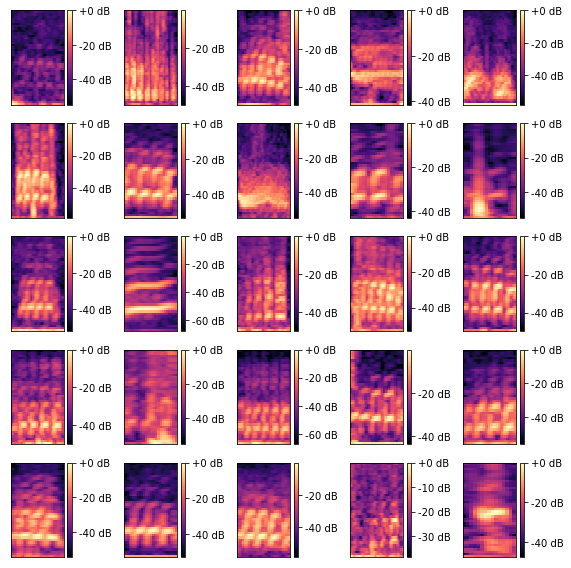

In [56]:
df_subset = df.sample(n=25)
specs = df_subset.spectrograms.values

plt.figure(figsize=(8, 8))
for i,spec in enumerate(specs,1):
    plt.subplot(5, 5, i)
    librosa.display.specshow(spec)
    plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

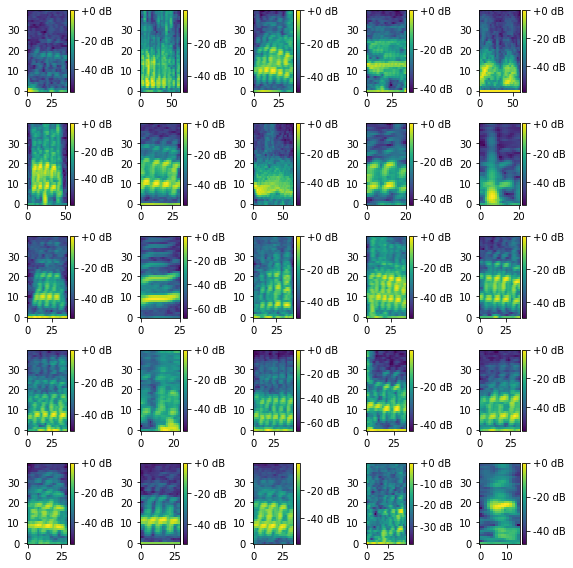

In [57]:
plt.figure(figsize=(8, 8))
for i,spec in enumerate(specs,1):
    plt.subplot(5, 5, i)
    plt.imshow(spec, interpolation='nearest', origin='lower', aspect='auto')
    plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

# Generate stretched spectrograms

In [4]:
df = pd.read_pickle(os.path.join(os.path.sep, DATA, "df_focal.pkl"))

In [5]:
MAX_DURATION = 0.5

In [9]:
spectrograms = df.apply(lambda row: generate_stretched_mel_spectrogram(row['raw_audio'],
                                                                       row['samplerate_hz'], 
                                                                       row['duration_s'],
                                                                       N_MELS,
                                                                       WINDOW,
                                                                       FFT_WIN,
                                                                       FFT_HOP),
                        axis=1)

df['stretched_spectrograms'] = spectrograms
df['stretched_denoised_spectrograms'] = [(spectrogram - np.median(spectrogram, axis=0)) for spectrogram in df['stretched_spectrograms']]

# Generate MFCCs

In [26]:
mfccs = [librosa.feature.mfcc(S=spectro,n_mfcc=N_MFCC) for spectro in df['stretched_spectrograms']]
df['stretched_mfccs'] = mfccs

In [27]:
mfccs = [librosa.feature.mfcc(S=spectro,n_mfcc=N_MFCC) for spectro in df['spectrograms']]
df['mfccs'] = mfccs

# Generate spectrograms on frequency scale

In [37]:
freq_spectrograms = df.apply(lambda row: generate_freq_spectrogram(row['raw_audio'],
                                                                   row['samplerate_hz'],
                                                                   WINDOW,
                                                                   FFT_WIN,
                                                                   FFT_HOP),
                             axis=1)


df['freq_spectrograms'] = freq_spectrograms

In [6]:
shapes = [s.shape[0] for s in df.freq_spectrograms]
pd.Series(shapes).value_counts()

121    17763
721     2951
dtype: int64

Because of different sampling rate, resulting spectrograms have different range of frequency. Resolution is the same, but range is different.
See this for explanations:
http://localhost:8888/notebooks/Documents/MPI_work/projects/meerkat/master_thesis_analysis/meerkat_code/Spectrogram_Params.ipynb

In [7]:
freq_specs = [x[:121,:] if x.shape[0]==721 else x for x in df.freq_spectrograms]
df['freq_spectrograms'] = freq_specs

In [8]:
shapes = [s.shape[0] for s in df.freq_spectrograms]
pd.Series(shapes).value_counts()

121    20714
dtype: int64

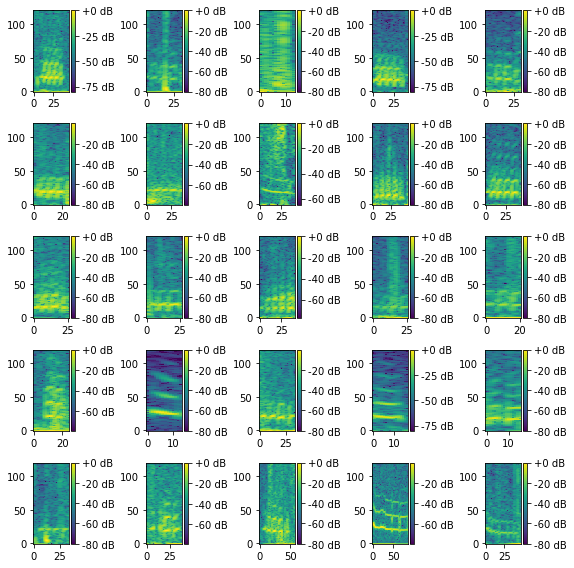

In [11]:
df_subset = df.sample(n=25)
specs = df_subset.freq_spectrograms.values

plt.figure(figsize=(8, 8))
for i,spec in enumerate(specs,1):
    plt.subplot(5, 5, i)
    #librosa.display.specshow(spec)
    plt.imshow(spec, interpolation='nearest', origin='lower', aspect='auto')
    plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

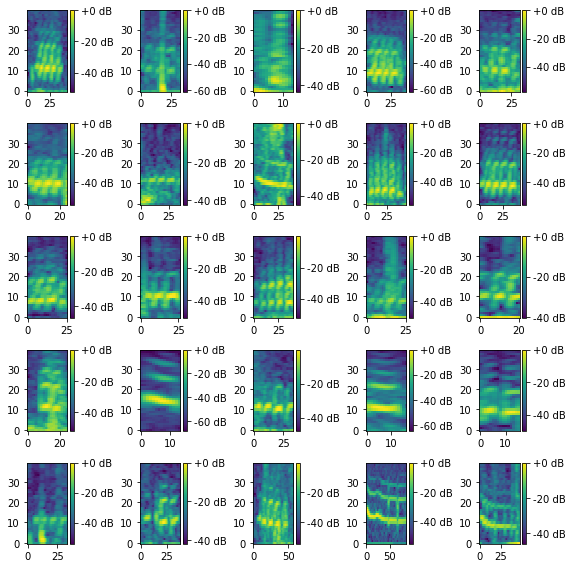

In [12]:
specs = df_subset.spectrograms.values

plt.figure(figsize=(8, 8))
for i,spec in enumerate(specs,1):
    plt.subplot(5, 5, i)
    #librosa.display.specshow(spec)
    plt.imshow(spec, interpolation='nearest', origin='lower', aspect='auto')
    plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

# Generate spectrograms on magnitude scale

In [23]:
ampli_specs = df.apply(lambda row: generate_ampli_spectrogram(row['raw_audio'],
                                                               row['samplerate_hz'],
                                                               WINDOW,
                                                               FFT_WIN,
                                                               FFT_HOP),
                             axis=1)

df['ampli_spectrograms'] = ampli_specs

In [24]:
shapes = [s.shape[0] for s in df.ampli_spectrograms]
pd.Series(shapes).value_counts()

121    17763
721     2951
dtype: int64

In [25]:
ampli_specs = [x[:121,:] if x.shape[0]==721 else x for x in df.ampli_spectrograms]
df['ampli_spectrograms'] = ampli_specs
shapes = [s.shape[0] for s in df.ampli_spectrograms]
pd.Series(shapes).value_counts()

121    20714
dtype: int64

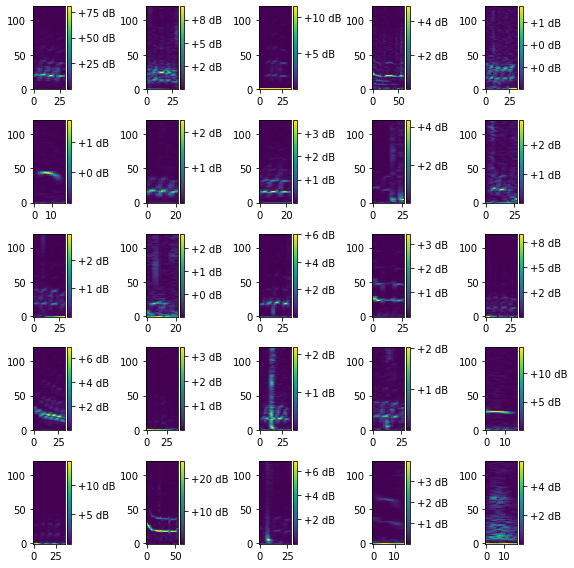

In [27]:
df_subset = df.sample(n=25)
specs = df_subset.ampli_spectrograms.values

plt.figure(figsize=(8, 8))
for i,spec in enumerate(specs,1):
    plt.subplot(5, 5, i)
    #librosa.display.specshow(spec)
    plt.imshow(spec, interpolation='nearest', origin='lower', aspect='auto')
    plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

# Save full labelfile

In [28]:
df.columns

Index(['Name', 'Start', 'Duration', 'Time Format', 'Type', 'Description',
       'start_s', 'duration_s', 'stop_s', 'date', 'samplerate_hz', 'indv',
       'original_wav', 'bout_number', 'Time.Format', 'call_lable',
       'certain_yn', 'nonfocal_yn', 'raw_audio', 'soundfoc_yn', 'spectrograms',
       'denoised_spectrograms', 'stretched_spectrograms',
       'stretched_denoised_spectrograms', 'stretched_mfccs', 'mfccs',
       'freq_spectrograms', 'ampli_spectrograms'],
      dtype='object')

In [29]:
df.to_pickle(os.path.join(os.path.sep, DATA, "df_focal.pkl"))

In [5]:
df = pd.read_pickle(os.path.join(os.path.sep, DATA, "df_focal.pkl"))
df.shape

(20714, 27)

In [34]:
df.columns

Index(['Name', 'Start', 'Duration', 'Time Format', 'Type', 'Description',
       'start_s', 'duration_s', 'stop_s', 'date', 'samplerate_hz', 'indv',
       'original_wav', 'bout_number', 'Time.Format', 'call_lable',
       'certain_yn', 'nonfocal_yn', 'raw_audio', 'soundfoc_yn', 'spectrograms',
       'denoised_spectrograms', 'stretched_spectrograms',
       'stretched_denoised_spectrograms', 'stretched_mfccs', 'mfccs'],
      dtype='object')